### Fernando Piani  
### January 5, 2022

# Hotel Booking Cancellations - A Binary Classification Case Study

### Introduction

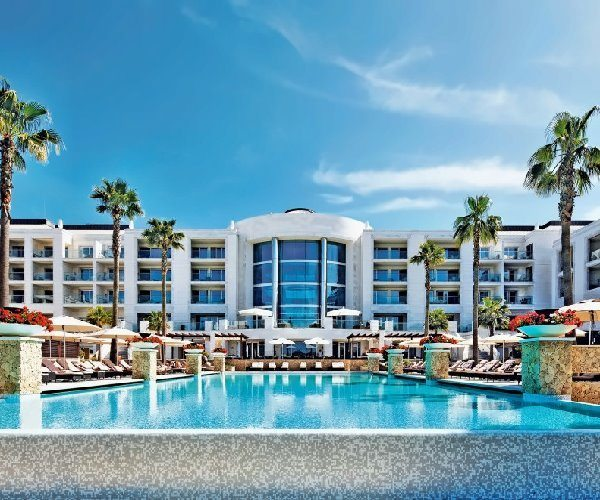

In this project, we will dive into the world of machine learning applications for revenue management and demand forecasting using a case study from the hospitality industry. Specifically, we will be analyzing a dataset containing information on hotel reservations with the ultimate goal of building a model to predict whether or not a booking will eventually be canceled.

In machine learning terms, we have a binary classification task at hand: we will utilize the 35 features provided in the original dataset to predict the value of the target categorical variable, is_canceled (with possible values "yes" or "no"). 

We will roughly follow the Cross Industry Process for Data Mining, or [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/), framework as our guiding methodology.  

The dataset, retrieved on this [Kaggle](https://www.kaggle.com/mojtaba142/hotel-booking) page, was originally published with the article [*Hotel booking demand datasets*](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by Antonio et al (link contains full data description in Table 1). In essence, it contains real data on reservations made for two different hotels in Portugal between July 2015 and August 2017. For the purposes of reproducibility, I have also uploaded the raw data to this project's GitHub repository.

### Business Understanding/Goal-Setting

In this project, we are a hotel attempting to predict whether a certain reservation will be canceled. Maximizing overall prediction accuracy is of course paramount, as it will allow for better revenue forecasting and the maximization of inventory capacity at all times. There is, however, a bit more nuance in that is imperative that we are highly confident of our model's decision when it predicts that a particular reservation will be canceled. 

In statistical terms, our null hypothesis is that a reservation will not be canceled, and the alternative is that it will be canceled. Making a Type I error in this situation would then be to incorrectly reject the null hypothesis, or incorrectly predict a cancellation where there will be none. A Type II error would be to fail in detecting a cancellation.

In our case, making a Type I error would be significantly more costly than a Type II error. One of the main potential use cases for this model, as we described earlier, is helping hotels reach maximum capacity by continuing to advertise (or even potentially double book) rooms taken up by a reservation that our model predicts will be eventually canceled. With that being said, canceling our double-booking legitimate reservations can be extremely damaging to customer satisfaction and brand image.

A Type II error, or failing to detect a cancellation, does have the negative impact of potentially leading to empty rooms. However, in this case, there is no potential impact of ruining legitimate reservations. Additionally, given that reservations can, in many cases, be canceled with enough notice to advertise to and attract new guests, not all of them will lead to unfilled inventory and lost revenue. 

Taking that into consideration, while the main goal will be to maximize our model's accuracy, we will also be more concerned with minimizing false positives than false negatives. In statistical terms, we will prioritize precision over recall.

### Exploratory Data Analysis (Data Understanding)

In [4]:
# Essential data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [10]:
%matplotlib inline

In [12]:
# Reading data
raw_data = pd.read_csv('https://raw.githubusercontent.com/fernandopiani/hotel-cancellation-project/main/Data/hotel_booking.csv')

In [14]:
print(raw_data.shape)
print(raw_data.head())

(119390, 36)
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  customer_type  \
0                        0                     0       2  ...      Tran

In [20]:
print(raw_data.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [15]:
# Percentage of missing values in each column
print((raw_data.isna().sum()/len(raw_data)))

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

In [32]:
# Counting number of unique values in each column
raw_data.nunique()

hotel                                  2
is_canceled                            2
lead_time                            479
arrival_date_year                      3
arrival_date_month                    12
arrival_date_week_number              53
arrival_date_day_of_month             31
stays_in_weekend_nights               17
stays_in_week_nights                  35
adults                                14
children                               5
babies                                 5
meal                                   5
country                              177
market_segment                         8
distribution_channel                   5
is_repeated_guest                      2
previous_cancellations                15
previous_bookings_not_canceled        73
reserved_room_type                    10
assigned_room_type                    12
booking_changes                       21
deposit_type                           3
agent                                333
company         

In [17]:
# Checking value counts of columns with missing values
missing_data_cols = ['country', 'agent', 'company']
for col in missing_data_cols:
    print(raw_data[col].value_counts())

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
KIR        1
ATF        1
SDN        1
NAM        1
MDG        1
Name: country, Length: 177, dtype: int64
9.0      31961
240.0    13922
1.0       7191
14.0      3640
7.0       3539
         ...  
304.0        1
431.0        1
278.0        1
450.0        1
114.0        1
Name: agent, Length: 333, dtype: int64
40.0     927
223.0    784
67.0     267
45.0     250
153.0    215
        ... 
273.0      1
415.0      1
352.0      1
253.0      1
497.0      1
Name: company, Length: 352, dtype: int64


Let's use the msno library to further examine missing values and understand if there is any bias in the data.

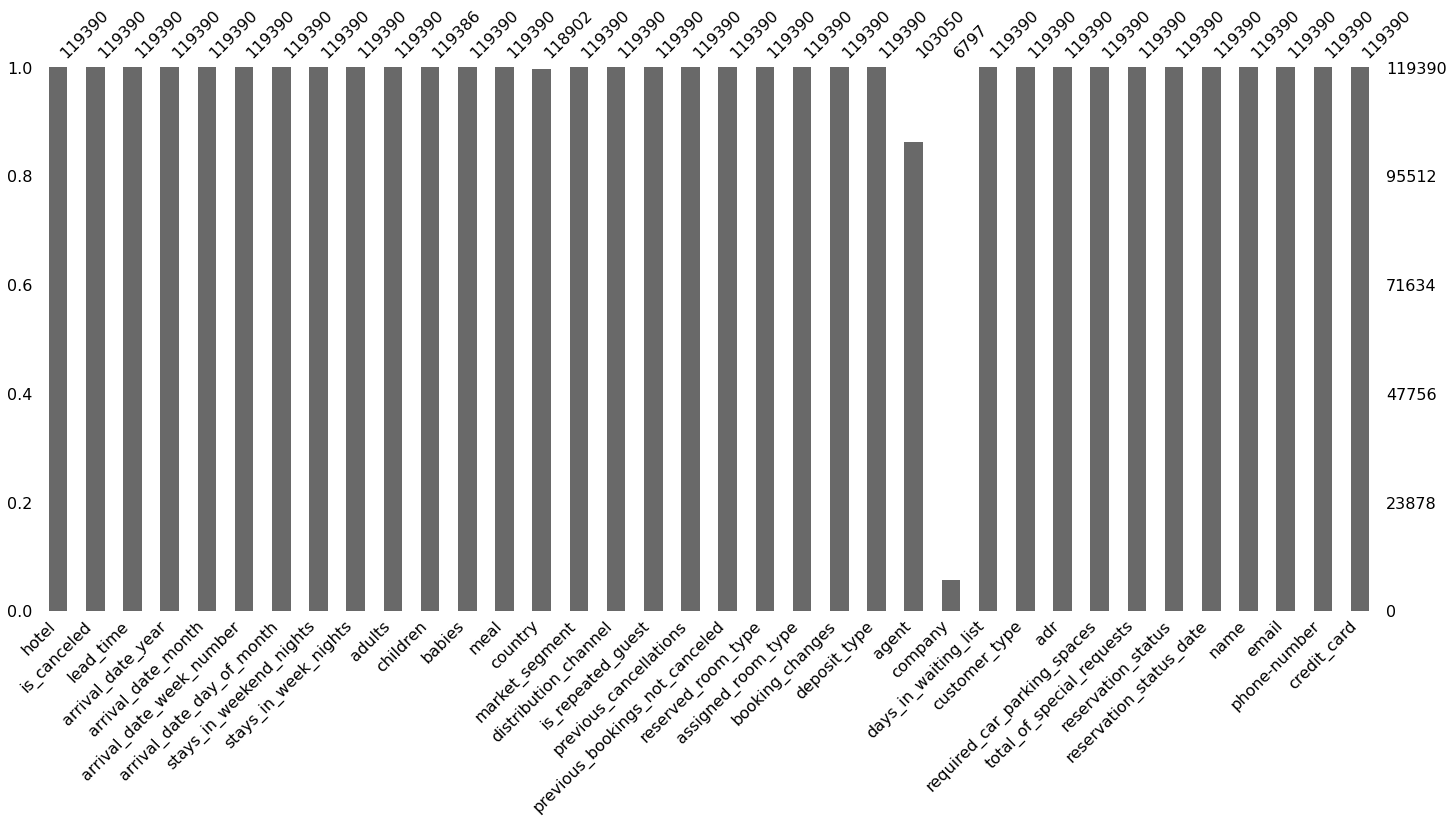

In [18]:
import missingno as msno
# Building bar chart of non-missing values per feature
_ = msno.bar(raw_data)

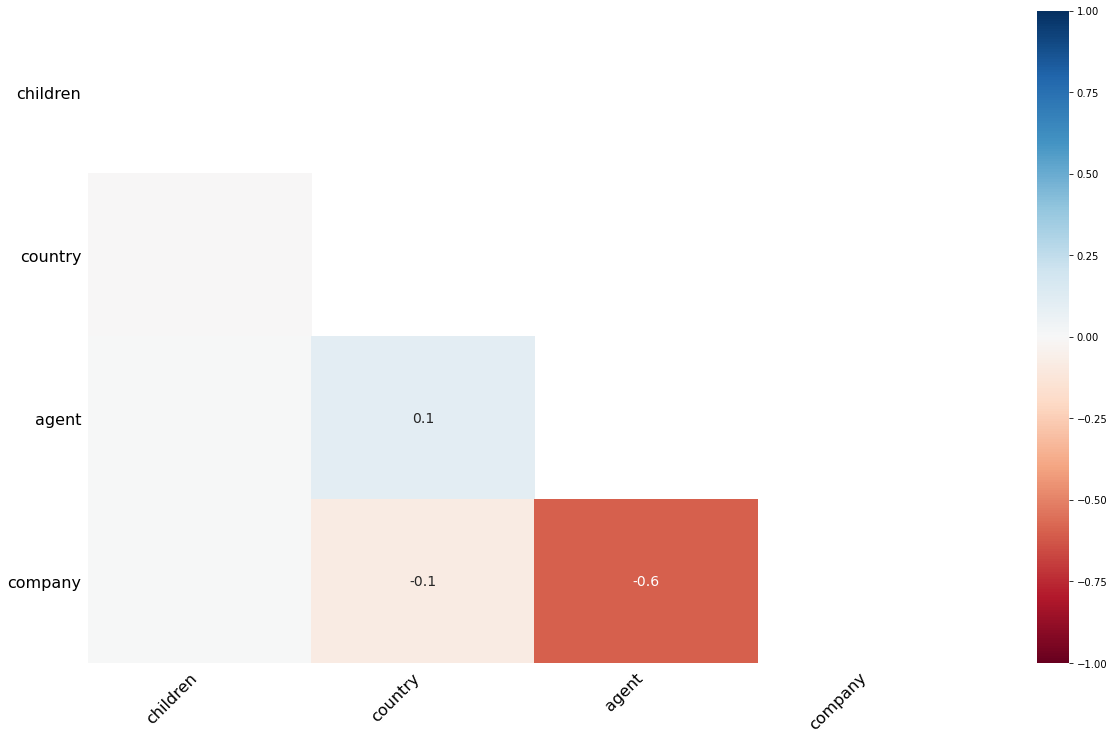

In [19]:
# Building heatmap of correlations
_ = msno.heatmap(raw_data)

The heatmap above shows a relatively strong negative correlation between the nullity of the agent and company features. In other words, samples with one of these features having a null value tend to have a non-null value for the other feature. This is to be expected given that business travelers would have their bookings handled by their company and a subset of leisure travelers would have their bookings handled by their travel agent. 

No other strong correlations were found here, hence we can assume there is no selection bias with respect to missing values in this dataset and proceed with our analysis.

In any classification task, it is essential to check is the whether or not we have imbalanced classes. This is because most machine learning algorithms perform better when classes are split about evenly. If the opposite is true, there several techniques and algorithm selection decisions that a data scientist must implement in order to build a model that can generalize well to real world data.

In [16]:
# Checking percentage of both values of the target categorical variable
raw_data['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

Given that we are at about a 60/40 split, we can proceed with our analysis without the need for any advanced resampling techniques or specific algorithm choices to deal with imbalanced data. We will simply use the *stratify* parameter of the sklearn function *train_test_split* so that both train and test sets also contain this 60/40 split.  

Our next step will be to split the data into a train and test set and perform a few last steps EDA steps on just the training data, so as to avoid any "data snooping" bias.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_set, test_set = train_test_split(raw_data, test_size = 0.2, random_state = 42,\
                                       stratify = raw_data['is_canceled'])

In [23]:
# Copy train set for further EDA
hotels = train_set.copy()

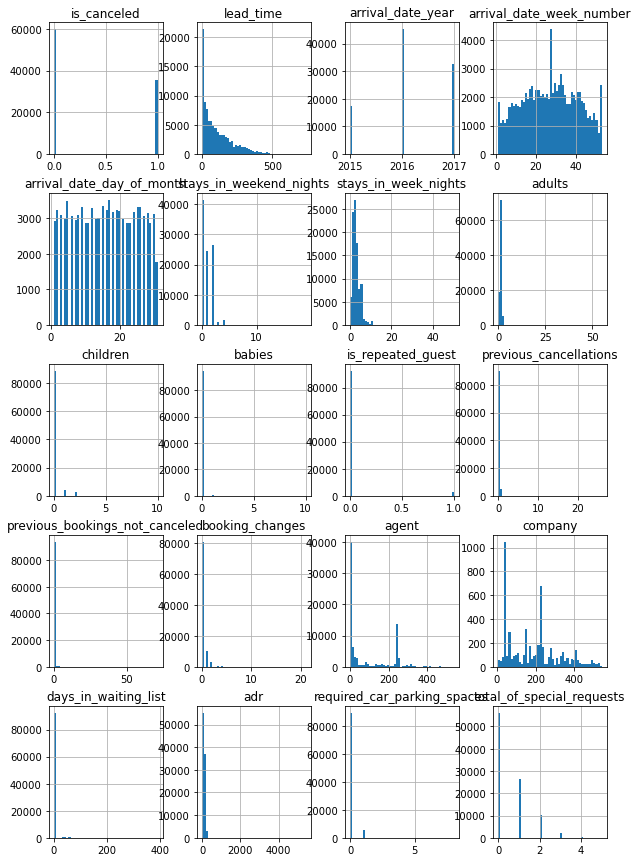

In [24]:
# Histogram of all numerical variables
_ = hotels.hist(bins=50, figsize=(10,15))

In [25]:
# Examining correlations
corr_matrix = hotels.corr()
corr_matrix['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293034
previous_cancellations            0.111525
adults                            0.057953
days_in_waiting_list              0.053600
adr                               0.046147
stays_in_week_nights              0.025650
arrival_date_year                 0.017537
arrival_date_week_number          0.007270
children                          0.005648
stays_in_weekend_nights           0.000977
arrival_date_day_of_month        -0.006720
company                          -0.023931
babies                           -0.030659
previous_bookings_not_canceled   -0.057203
agent                            -0.079114
is_repeated_guest                -0.086247
booking_changes                  -0.141886
required_car_parking_spaces      -0.194639
total_of_special_requests        -0.236955
Name: is_canceled, dtype: float64

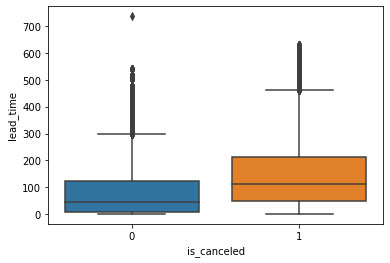

In [26]:
# Zooming into relationship between lead_time and is_canceled
_ = sns.boxplot(x='is_canceled', y='lead_time', data=hotels)

The data represented by the boxplot above aligns with our intuition - bookings made far in advance are somewhat more prone to cancellations given that there is more time for plans to change.

#### Feature engineering  

One last step we can take before the data preparation stage is to play around with our existing features and combinations thereof to create new features with potential explanatory power.

In [27]:
# Creating average daily rate per person and a.v.r. per adult features and computing correlations
hotels['adr_per_person'] = hotels['adr']/(hotels['adults'] + hotels['children'] + hotels['babies'])
hotels['adr_per_adult'] = hotels['adr']/hotels['adults']
corr_matrix = hotels.corr()
corr_matrix['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293034
previous_cancellations            0.111525
adults                            0.057953
days_in_waiting_list              0.053600
adr                               0.046147
stays_in_week_nights              0.025650
adr_per_adult                     0.018660
adr_per_person                    0.018597
arrival_date_year                 0.017537
arrival_date_week_number          0.007270
children                          0.005648
stays_in_weekend_nights           0.000977
arrival_date_day_of_month        -0.006720
company                          -0.023931
babies                           -0.030659
previous_bookings_not_canceled   -0.057203
agent                            -0.079114
is_repeated_guest                -0.086247
booking_changes                  -0.141886
required_car_parking_spaces      -0.194639
total_of_special_requests        -0.236955
Name: is_canceled, dtype: float64

As we can see, neither of our engineered variables are highly correlated with the target categorical variable. In fact, they both have lower correlation coefficients than the non-transformed *adr* variable itself. For this reason, as well for the purpose of model simplicity, we will drop these variables from the final training data.

In [28]:
# Resetting train set and separating features from labels
hotels = train_set.drop('is_canceled', axis=1)
hotel_labels = train_set['is_canceled'].copy()

### Data Preparation

We are now ready to begin preparing our data for the machine learning algorithms we will use to make predictions. We will follow industry best practices by creating functions and pipelines to automatically perform the necessary transformations, allowing for easier experimentation and (in many real-world cases) deployment.

Our first step in this stage will be to distinguish numerical and categorical features in order to later apply the appropriate transformations to each. We will also drop the columns *company* since nearly 95% of its values are missing, and *agent* due to its large number of missing values and lack of interpretability (since it is an agent ID number).

In [29]:
# Storing categorical columns for future reference
CAT_COLS = ['hotel', 'arrival_date_month', 'market_segment','distribution_channel', \
                    'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', \
                           'deposit_type', 'customer_type', 'reservation_status']

# Storing numeric columns by creating a correlation matrix (which only uses numbers) and getting its index
NUM_COLS = list(hotels.corr().index)

In [30]:
print(NUM_COLS)

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [31]:
# Removing column that is in fact a cat. variable
NUM_COLS.remove('is_repeated_guest')

Notice that the *country* column is not included in the *CAT_COLS* list above. This is because we will treat it separately due to its high dimensionality. As it is a categorical variable with 177 unique values, we should not apply standard encoding techniques to *country*, as doing so will exponentially increase the size our dataset and thus computational complexity.  

Our goal here will be to reduce the number of categories of this feature in such a way as to preserve the most important instances. Additionally, we want to automate this process so that it can live within a Scikit-learn pipeline and transform unseen data. Because of Scikit-learn's object-oriented framework, we will need to create a new class to implement our transformer.

#### Custom Transformer creation

In [33]:
# Importing helper classes for our transformer 
from sklearn.base import BaseEstimator, TransformerMixin

# Creating countries variable to test our new transformer
countries = hotels[['country']].copy()

In [41]:
# Transformer that limits classes based on user-selected percentage of instances
class CategoryLimiter(BaseEstimator, TransformerMixin):

	def __init__(self, threshold):
		self.threshold = threshold

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		values_pct = pd.DataFrame(X.value_counts(normalize=True))
		cumsum = np.cumsum(values_pct.iloc[:,0])
		z = np.argmax(cumsum >= self.threshold) + 1
		top_z_categories = list(values_pct.index[:z])
		other_cats = set(list(values_pct.index)).difference(set(top_z_categories))
		other_cats = list(other_cats)
		X.replace(other_cats, 'Other', inplace=True)
		return X

Now, we'll run a quick test of our custom transformer using the data copy we created above.

In [119]:
# Instatiating CategoryLimiter that will preserve categories accounting for 95% of instances
cat_lim = CategoryLimiter(threshold = 0.95)

# Fitting and transforming to a copy of the train set country column
test = cat_lim.fit_transform(countries)

In [120]:
test.value_counts().shape

(24,)

The above cell indicates that we have successfully limited the number of categories of the country feature from 177 to 24, thus making it much simpler computationally for our machine learning algorithms while preserving its most important values.

#### Pipeline creation  

With our CategoryLimiter custom transformer created and quality checked, we can now move on to the creation of our data transformation pipelines. These will incorporate and implement CategoryLimiter along with several other built-in Scikit-learn transformers that will ready our data for the modeling stage.

For our numerical data, we will apply SimpleImputer to fill in missing values with 0. Even though no samples are missing numerical data (not including the *agent* or *company* columns, both since dropped for modeling purposes) in our original dataset, this step will ensure our model can work on unseen, real-world data - which may indeed contain missing values. We will then standardize this data using Scikit-learn's StandardScaler to make it more digestible to machine learning algorithms.

We will apply the same imputation strategy (i.e. SimpleImputer and constant value) to our country data, with the only difference being that we will fill missing values with 'Other' to match our CategoryLimiter transformer - the next step in the pipeline. Then, we will use OneHotEncoder to create dummy features for each category/country. 

The other categorical features will be transformed in the same way as the country column, with the exception of the CategoryLimiter step.

We will then use Scikit-learn's ColumnTransformer class to unite the transformed numerical, country, and categorical data. Lastly, we will utilize a dimensionality reduction technique to the aggregated transformed data in order to reduce the number of columns before modeling.

In [48]:
# Sklearn transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [61]:
# Creating pipelines
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)), \
                         ('std_scaler', StandardScaler())])


country_pipeline = Pipeline([('limiter', CategoryLimiter(threshold=0.95)), \
                             ('imputer', SimpleImputer(strategy='constant', fill_value='Other')), \
                                    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Other')), \
                                    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

In [52]:
# Creating country column constant
COUNTRY_COL = ['country']

In [50]:
# Importing dimensionality reduction tool
from sklearn.decomposition import TruncatedSVD

In [62]:
# Full pipeline object, with appropriate transformations for each column type united by a ColumnTransformer
# object followed by a TruncatedSVD reducing the dataset to features capturing 95% of the variance
full_pipeline = Pipeline([('column_transformer', ColumnTransformer([('num', num_pipeline, NUM_COLS), \
                                ('country', country_pipeline, COUNTRY_COL), \
                                      ('cat', cat_pipeline, CAT_COLS)])), \
                                          ('svd', TruncatedSVD(n_components=36, random_state=42))])

The dimensionality reduction technique we chose here was TruncatedSVD, an algorithm which works especially well with sparse matrices because it does not center the data before decomposition. Since the OneHotEncoder steps in the pipeline transformed our data into a sparse matrix (containing many dummy features), TruncatedSVD was a more computationally efficient choice than PCA.

Additionally, I have ommitted a quick computation of lowest number of features needed to reach an explained variance ratio of 95% - this number turned out to be 36, as seen above.

### Modeling/Evaluation

Now, we are ready to proceed to the modeling stage. We'll start by selecting 3 base models with default parameters and computing their accuracy then maximizing the accuracy of the best-performing initial model. In evaluating performance, we will also create helper functions to compute cross-validated accuracy, in addition to precision and recall.

In [54]:
# Resetting our train and test sets
hotels = train_set.drop('is_canceled', axis=1)
hotel_labels = train_set['is_canceled'].copy()
hotels_test = test_set.drop('is_canceled', axis=1).copy()
hotel_test_labels = test_set['is_canceled'].copy()

In [63]:
# Transforming train set using pipeline we created
hotels_prepared = full_pipeline.fit_transform(hotels)

In [64]:
# Transforming, but not fitting test set for final predictions later on
hotels_test_prepared = full_pipeline.transform(hotels_test)

In [82]:
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation functions
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Computation time
import time

#### Helper Functions

In [80]:
def cv_classifier_accuracy(model, X, y, cv):
	"""Computes mean and std. dev. of cross-validated accuracy scores based on user-defined number of folds."""

	start = time.time()

	# Compute cross-validated accuracy scores
	cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

	# Print list of Acc. scores
	print(f"Mean accuracy score computed using {cv}-fold cross-validation: {cv_accuracy.mean()}")
	print(f"Accuracy score std. deviation computed using {cv}-fold cross-validation: {cv_accuracy.std()}")
	print(f"Computation time: {time.time() - start}")


def cv_classifier_stats(model, X, y, cv):
	"""Computes cross-validated predictions and outputs their precision and recall scores and confusion matrix against 
		the train set."""

	start = time.time()

	# Generates cross-validated predictions for each input data point 
	pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

	# Print relevant metrics
	print(f"Precision score computed using {cv}-fold cross-validation: {precision_score(y, pred)}")
	print(f"Recall score computed using {cv}-fold cross-validation: {recall_score(y, pred)}")
	print(f"Confusion matrix computed using {cv}-fold cross-validation: {confusion_matrix(y, pred)}")
	print(f"Computation time: {time.time() - start}")

#### Base Model Selection

In [75]:
# List of models we will evaluate, as mentioned above
models = [KNeighborsClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

In [78]:
# Computing accuracy score for each base model using 10-fold cross-validation
for model in models:
	cv_classifier_accuracy(model, hotels_prepared, hotel_labels, 10)

Mean accuracy score computed using 10-fold cross-validation: 0.9775630389935228
Accuracy score std. deviation computed using 10-fold cross-validation: 0.0018599190859892912
Computation time: 84.31540179252625
Mean accuracy score computed using 10-fold cross-validation: 0.9952780854943057
Accuracy score std. deviation computed using 10-fold cross-validation: 0.0005856147940461956
Computation time: 122.26956820487976
Mean accuracy score computed using 10-fold cross-validation: 0.9951419653234238
Accuracy score std. deviation computed using 10-fold cross-validation: 0.000713532409350825
Computation time: 280.25656604766846


In [81]:
# Computing additional metrics for each base model using 10-fold cross-validation
for model in models:
	cv_classifier_stats(model, hotels_prepared, hotel_labels, 10)

Precision score computed using 10-fold cross-validation: 0.9871885077689827
Recall score computed using 10-fold cross-validation: 0.9517793041069561
Confusion matrix computed using 10-fold cross-validation: [[59696   437]
 [ 1706 33673]]
Computation time: 84.57733583450317
Precision score computed using 10-fold cross-validation: 0.9997137786936859
Recall score computed using 10-fold cross-validation: 0.9872523248254614
Confusion matrix computed using 10-fold cross-validation: [[60123    10]
 [  451 34928]]
Computation time: 122.53745317459106
Precision score computed using 10-fold cross-validation: 0.9989710463886586
Recall score computed using 10-fold cross-validation: 0.9879024279940077
Confusion matrix computed using 10-fold cross-validation: [[60097    36]
 [  428 34951]]
Computation time: 274.1306641101837


Therefore, we can select the random forest algorithm from which we will build our model.  

Not only did it provide the best overall accuracy score, but it also had the highest precision score, which was the most important metric for our business case. While its training time was 40 seconds higher than that of the KNN algorithm, it did provide a 1.3% improvement in precision and 4% improvement in recall.

We've seen the performance using the base parameters, but now let's see if we can optimize it even further and/or perhaps reduce its computation time.

#### Hyperparameter Tuning

In [83]:
# Instatiating a RandomForestClassifier
forest_clf = RandomForestClassifier()

# Creating parameter grid
param_grid = [{'n_estimators': [100, 150, 200], 'warm_start': [False, True]}]

# Creating GridSearch object using 10-fold cross-validation and precision as the utility function
grid_search = GridSearchCV(forest_clf, param_grid, cv=10, scoring='precision', n_jobs=-1)

# Fitting grid to training data
grid_search.fit(hotels_prepared, hotel_labels)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'n_estimators': [100, 150, 200],
                          'warm_start': [False, True]}],
             scoring='precision')

In [84]:
# Finding best parameters
grid_search.best_params_

{'n_estimators': 200, 'warm_start': True}

Lastly, we'll do a head-to-head comparison of the base model and the best estimator as computed by the Grid Search to assess more performance metrics as well as training time. Then we'll make our final model decision.

In [86]:
# Listing two final models

forest_base = RandomForestClassifier()
forest_gs = grid_search.best_estimator_
final_models = [forest_base, forest_gs]

In [88]:
# Computing accuracy score for each base model using 10-fold cross-validation
for model in final_models:
	cv_classifier_accuracy(model, hotels_prepared, hotel_labels, 10)

Mean accuracy score computed using 10-fold cross-validation: 0.99515244091185
Accuracy score std. deviation computed using 10-fold cross-validation: 0.0005172933148631947
Computation time: 128.38732504844666
Mean accuracy score computed using 10-fold cross-validation: 0.9954456028353121
Accuracy score std. deviation computed using 10-fold cross-validation: 0.0006491840375817313
Computation time: 246.49274826049805


In [89]:
# Computing additional metrics for each base model using 10-fold cross-validation
for model in final_models:
	cv_classifier_stats(model, hotels_prepared, hotel_labels, 10)

Precision score computed using 10-fold cross-validation: 0.9996853456906662
Recall score computed using 10-fold cross-validation: 0.9878176319285452
Confusion matrix computed using 10-fold cross-validation: [[60122    11]
 [  431 34948]]
Computation time: 122.77610993385315
Precision score computed using 10-fold cross-validation: 0.9997711670480549
Recall score computed using 10-fold cross-validation: 0.987930693349162
Confusion matrix computed using 10-fold cross-validation: [[60125     8]
 [  427 34952]]
Computation time: 248.32206296920776


As we can see above, the tweaked model generates a negligible improvement to accuracy, precision, and recall (small enough that it will most likely not generalize to new data), at the expense of a doubled computation time. For this reason, we will stick with the base random forest model.

In [92]:
# Creating and fitting final random forest model with default parameters
final_model = RandomForestClassifier().fit(hotels_prepared, hotel_labels)

#### Predicting on the test set

In [93]:
final_predictions = final_model.predict(hotels_test_prepared)

In [94]:
confusion_matrix(hotel_test_labels, final_predictions)

array([[15030,     3],
       [  108,  8737]])

In [95]:
precision_score(hotel_test_labels, final_predictions)

0.9996567505720824

In [97]:
recall_score(hotel_test_labels, final_predictions)

0.9877897117015263

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
accuracy_score(hotel_test_labels, final_predictions)

0.9953513694614289

Lastly, let's build a 95% confidence interval for our model's accuracy score. In order to do so, we must note that we are dealing with a Binomial distribution, since we are examining the proportion of prediction successes - a yes or no question. We will utilize the *statsmodels* library, which containts the relevant *proportion_confint* function for this purpose.

In [106]:
# Importing relevant statistical function
from statsmodels.stats.proportion import proportion_confint

In [109]:
# Fetching binomial distribution parameters
n = len(final_predictions)
p = accuracy_score(hotel_test_labels, final_predictions)

In [113]:
# Calculating 95% confidence interval of accuracy score
conf_int = proportion_confint(count = n*p, nobs = n, alpha = (0.05))
print(conf_int)

(0.9944885899134057, 0.996214149009452)


In [115]:
# Calculating margin of error
margin_of_error = p - conf_int[0]
print(margin_of_error)

0.0008627795480231626


### Conclusion and Final Thoughts

Now, thinking back to the original business problem - we wanted to maximize our overall accuracy in predicting cancellations while prioritizing our model's precision over recall. As we've mentioned above, in this situation, making a Type I error (i.e. incorrectly predicting a cancellation where there will be none) is significantly more costly than making a Type II error.

We have arrived at a model with an overall accuracy score of 99.53%, and whose precision and recall scores are 99.96% and 98.77%, respectively. In other words - when our model flags a reservation as one that will be canceled we can expect it to be over 99% accurate. On the other hand, our model will fail to catch a slightly over 1% of all the reservations that will be eventually canceled. For the reasons outlined above, this is a more than satisfactory performance for our business case.